# New dataset

In [176]:
# TEST necessary for when working with external scripts
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [177]:
import pandas as pd

# import the data
data_df = pd.read_csv("hf://datasets/Senem/Nostalgic_Sentiment_Analysis_of_YouTube_Comments_Data/Nostalgic_Sentiment_Analysis_of_YouTube_Comments_Data.csv")

In [178]:
data_df.describe()

,sentiment,comment
count,1500,1500
unique,2,1499
top,not nostalgia,never heard this song before... WOW What an am...
freq,750,2


In [179]:
# verify if there are null values
data_df.isnull().sum()

sentiment    0
comment      0
dtype: int64

In [180]:
# delete duplicated rows
data_df.drop_duplicates(inplace=True)

In [181]:
import nltk
import helpers.data_mining_helpers as dmh

data_df['unigrams'] = data_df['comment'].apply(lambda x: dmh.tokenize_text(x))

In [182]:
data_df['unigrams'].head()

0    [He, was, a, singer, with, a, golden, voice, t...
1    [The, mist, beautiful, voice, ever, I, listene...
2    [I, have, most, of, Mr., Reeves, songs, ., Alw...
3    [30, day, leave, from, 1st, tour, in, Viet, Na...
4    [listening, to, his, songs, reminds, me, of, m...
Name: unigrams, dtype: object

<Axes: xlabel='sentiment'>

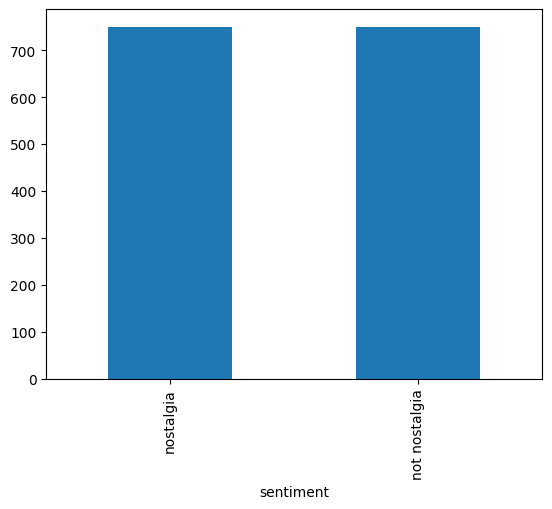

In [183]:
# plot number of comments by sentiment
data_df['sentiment'].value_counts().plot(kind='bar')


In [184]:
# Count patterns 
from sklearn.feature_extraction.text import CountVectorizer

nostalgic = data_df[data_df.sentiment == 'nostalgia']
non_nostalgic = data_df[data_df.sentiment == 'not nostalgia']

count_vect_nost = CountVectorizer()
nost_count = count_vect_nost.fit_transform(nostalgic.comment)
nost_feature_names = count_vect_nost.get_feature_names_out()
nost_term_doc = pd.DataFrame(nost_count.toarray(), columns=nost_feature_names)

count_vect_non_nost = CountVectorizer()
non_nost_count = count_vect_non_nost.fit_transform(non_nostalgic.comment)
non_nost_feature_names = count_vect_non_nost.get_feature_names_out()
non_nost_term_doc = pd.DataFrame(non_nost_count.toarray(), columns=non_nost_feature_names)


In [185]:
import numpy as np
# make term frequency matrix

nost_frequencies = np.asarray(nost_count.sum(axis=0))
non_nost_frequencies = np.asarray(non_nost_count.sum(axis=0))

In [186]:
# make frequency dataframe
term_frequencies_nost = pd.DataFrame(nost_frequencies, columns=nost_feature_names).transpose()
term_frequencies_non_nost = pd.DataFrame(non_nost_frequencies, columns=non_nost_feature_names).transpose()

term_frequencies_nost.columns = ['nostalgic']
term_frequencies_non_nost.columns = ['non_nostalgic']

term_frequencies_nost.sort_values(by='nostalgic', ascending=False).head(10)
term_frequencies_non_nost.sort_values(by='non_nostalgic', ascending=False).head(10)

,non_nostalgic
the,708
this,452
and,451
to,394
of,361
song,308
it,268
is,265
in,263
you,238


<Axes: >

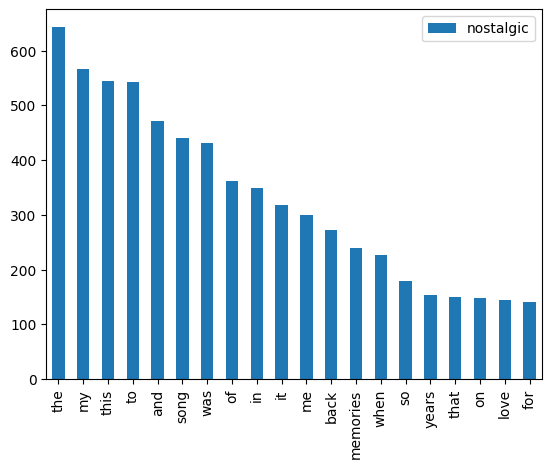

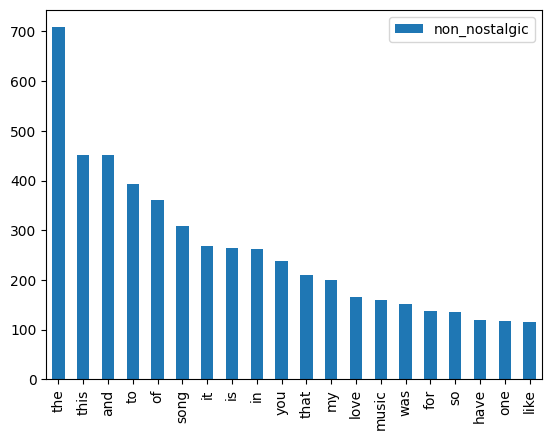

In [187]:
# plot the terms frequency for both sentiments

term_frequencies_nost.sort_values(by='nostalgic', ascending=False).head(20).plot(kind='bar')
term_frequencies_non_nost.sort_values(by='non_nostalgic', ascending=False).head(20).plot(kind='bar')


In [188]:
# remove top 5% and bottom 1% of terms
for doc in [nost_term_doc, non_nost_term_doc]:

    word_counts = doc.sum(axis=0).to_numpy()

    sorted_indices = np.argsort(word_counts)[::-1]  
    sorted_counts = np.sort(word_counts)[::-1]

    total_terms = len(sorted_counts)
    top_5_percent_index = int(0.05 * total_terms)
    bottom_1_percent_index = int(0.99 * total_terms)

    top_5_percent_indices = sorted_indices[:top_5_percent_index]
    bottom_1_percent_indices = sorted_indices[bottom_1_percent_index:]

    filtered_words = [doc.iloc[:, i].name for i in top_5_percent_indices]
    filtered_words += [doc.iloc[:, i].name for i in bottom_1_percent_indices]

    doc.drop(columns=filtered_words, inplace=True)


    print(f"Filtered terms: {filtered_words}")


Filtered terms: ['the', 'my', 'this', 'to', 'and', 'song', 'was', 'of', 'in', 'it', 'me', 'back', 'memories', 'when', 'so', 'years', 'that', 'on', 'love', 'for', 'time', 'you', 'remember', 'old', 'with', 'is', 'music', 'great', 'brings', 'we', 'beautiful', 'as', 'all', 'but', 'now', 'days', 'at', 'miss', 'good', 'songs', 'childhood', 'reminds', 'her', 'from', 'still', 'he', 'just', 'always', 'have', 'she', 'first', 'dad', 'many', 'had', 'much', 'listening', 'his', 'like', 'loved', 'up', 'used', 'school', 'were', 'very', 'am', 'one', 'those', 'voice', 'every', 'be', 'him', 'never', 'heard', 'times', 'these', 'can', 'listen', 'not', 'young', 'what', 'are', 'best', 'they', 'played', 'hear', 'thank', 'sing', 'out', 'how', 'life', 'happy', 'thanks', 'then', 'radio', 'again', 'ago', 'really', 'mum', 'who', 'an', 'day', 'play', 'mom', 'there', 'some', 'our', 'after', 'came', 'passed', 'makes', 'wonderful', 'singing', 'little', 'takes', 'ring', 'rightly', 'romanticism', 'grace', 'grabbed', 'ru

In [189]:
from PAMI.extras.convert.DF2DB import DF2DB            

# create transactional database
for doc, name in [(nost_term_doc, "nost"), (non_nost_term_doc, "non_nost")]:    

    obj = DF2DB(doc)           
        
    obj.convert2TransactionalDatabase(f'td_freq_db_{name}.csv', '>=', 1)

Database size (total no of transactions) : 734
Number of items : 2158
Minimum Transaction Size : 1
Average Transaction Size : 8.692098092643052
Maximum Transaction Size : 39
Standard Deviation Transaction Size : 7.212652953524106
Variance in Transaction Sizes : 52.0933344733115
Sparsity : 0.9959721510228716


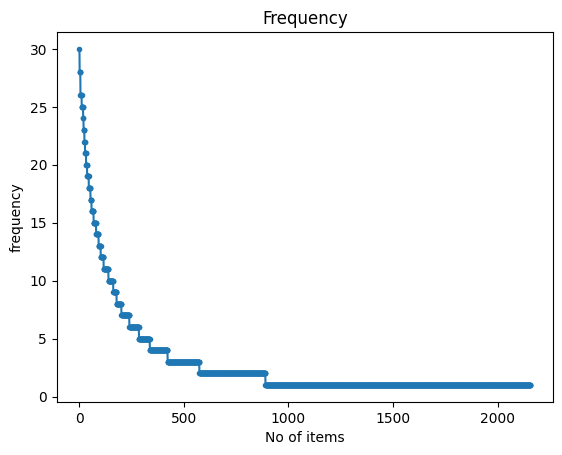

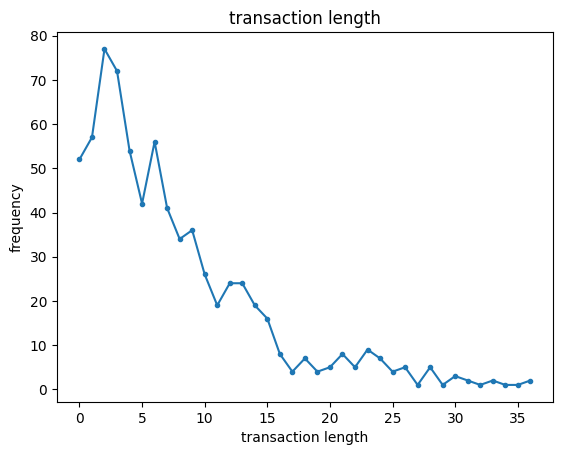

In [190]:
from PAMI.extras.dbStats import TransactionalDatabase as tds
obj = tds.TransactionalDatabase('td_freq_db_nost.csv')
obj.run()
obj.printStats()
obj.plotGraphs()

Database size (total no of transactions) : 745
Number of items : 2445
Minimum Transaction Size : 1
Average Transaction Size : 8.409395973154362
Maximum Transaction Size : 46
Standard Deviation Transaction Size : 5.925956352822239
Variance in Transaction Sizes : 35.16415890885473
Sparsity : 0.9965605742441086


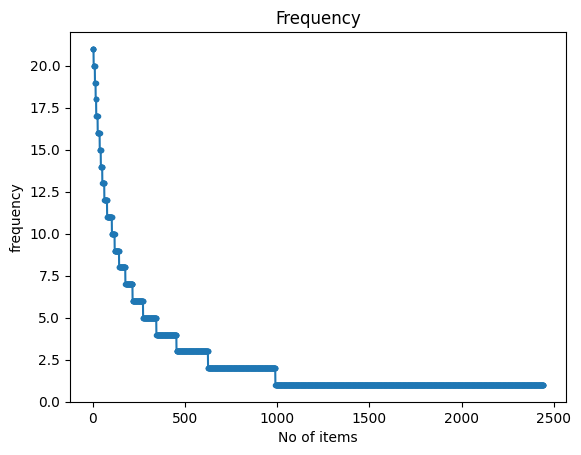

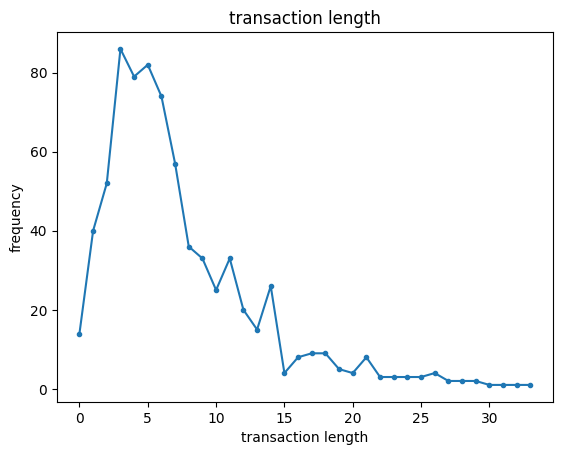

In [191]:
from PAMI.extras.dbStats import TransactionalDatabase as tds
obj = tds.TransactionalDatabase('td_freq_db_non_nost.csv')
obj.run()
obj.printStats()
obj.plotGraphs()

In [195]:
from PAMI.frequentPattern.topk import FAE as alg

k = 150

freq_patterns = {}

for file, name in [("td_freq_db_nost.csv", "nost"), ("td_freq_db_non_nost.csv", "non_nost")]:
    obj = alg.FAE(iFile=file, k=k)
    obj.mine()

    freq_patterns[name] = obj.getPatternsAsDataFrame()

    #obj.save(outFile=f'comp_graphs_FAE_{k}.txt')

    print(f'K: {k}')
    print('No. patterns:', len(patterns))
    print(patterns)
    print('Runtime: ' + str(obj.getRuntime()))

nost_freq_patterns = freq_patterns['nost']
non_nost_freq_patterns = freq_patterns['non_nost']

 TopK frequent patterns were successfully generated using FAE algorithm.
K: 150
No. patterns: 150
    Patterns  Support
0      elvis       21
1      every       21
2      loved       21
3    classic       21
4       them       21
..       ...      ...
145     hope        8
146     king        8
147   future        8
148    radio        8
149     used        8

[150 rows x 2 columns]
Runtime: 0.021097898483276367
 TopK frequent patterns were successfully generated using FAE algorithm.
K: 150
No. patterns: 150
    Patterns  Support
0      elvis       21
1      every       21
2      loved       21
3    classic       21
4       them       21
..       ...      ...
145     hope        8
146     king        8
147   future        8
148    radio        8
149     used        8

[150 rows x 2 columns]
Runtime: 0.017245054244995117


In [196]:
# get unique patterns
import pandas as pd

dfs = [nost_freq_patterns, non_nost_freq_patterns]


pattern_counts = {}
for df in dfs:
    for pattern in df['Patterns']:
        if pattern not in pattern_counts:
            pattern_counts[pattern] = 1
        else:
            pattern_counts[pattern] += 1

unique_patterns = {pattern for pattern, count in pattern_counts.items() if count == 1}
total_patterns_count = sum(len(df) for df in dfs)

# For each category, filter the patterns to keep only the unique ones
filtered_dfs = []
for df in dfs:
    filtered_df = df[df['Patterns'].isin(unique_patterns)]
    filtered_dfs.append(filtered_df)

# Merge the filtered dataframes into a final dataframe
final_pattern_df = pd.concat(filtered_dfs, ignore_index=True).sort_values(by='Support', ascending=False)

# Display the final result
print(final_pattern_df)


    Patterns  Support
0       ever       28
2       will       28
1      would       28
3        kid       26
5       such       26
..       ...      ...
207     hope        8
208     king        8
209   future        8
210    radio        8
211     used        8

[212 rows x 2 columns]


In [201]:
# Augment the features with the patterns
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

# comments into a term-document matrix
count_vect = CountVectorizer()
comment_tdm = count_vect.fit_transform(data_df["comment"])
terms = count_vect.get_feature_names_out()

data_df['tokenized_text'] = data_df['comment'].str.split().apply(set)

pattern_matrix = pd.DataFrame(0, index=data_df.index, columns=final_pattern_df['Patterns'])

for pattern in final_pattern_df['Patterns']:
    pattern_words = set(pattern.split())  # Tokenize pattern into words
    pattern_matrix[pattern] = data_df['tokenized_text'].apply(lambda x: 1 if pattern_words.issubset(x) else 0)

# Convert the term-document matrix to a DataFrame for easy merging
tdm_df = pd.DataFrame(comment_tdm.toarray(), columns=terms, index=data_df.index)

# Concatenate the original TDM and the pattern matrix to augment the features
augmented_df = pd.concat([tdm_df, pattern_matrix], axis=1)

augmented_df


,00,000,045,07,10,100,10m,11,11th,12,...,family,mind,soul,special,favorites,hope,king,future,radio,used
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1496,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1497,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1498,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [206]:
#Applying dimensionality reduction with only the document-term frequency data
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE



X_pca_tdm = PCA(n_components=3).fit_transform(tdm_df.values)
X_tsne_tdm = TSNE(n_components=3).fit_transform(tdm_df.values)

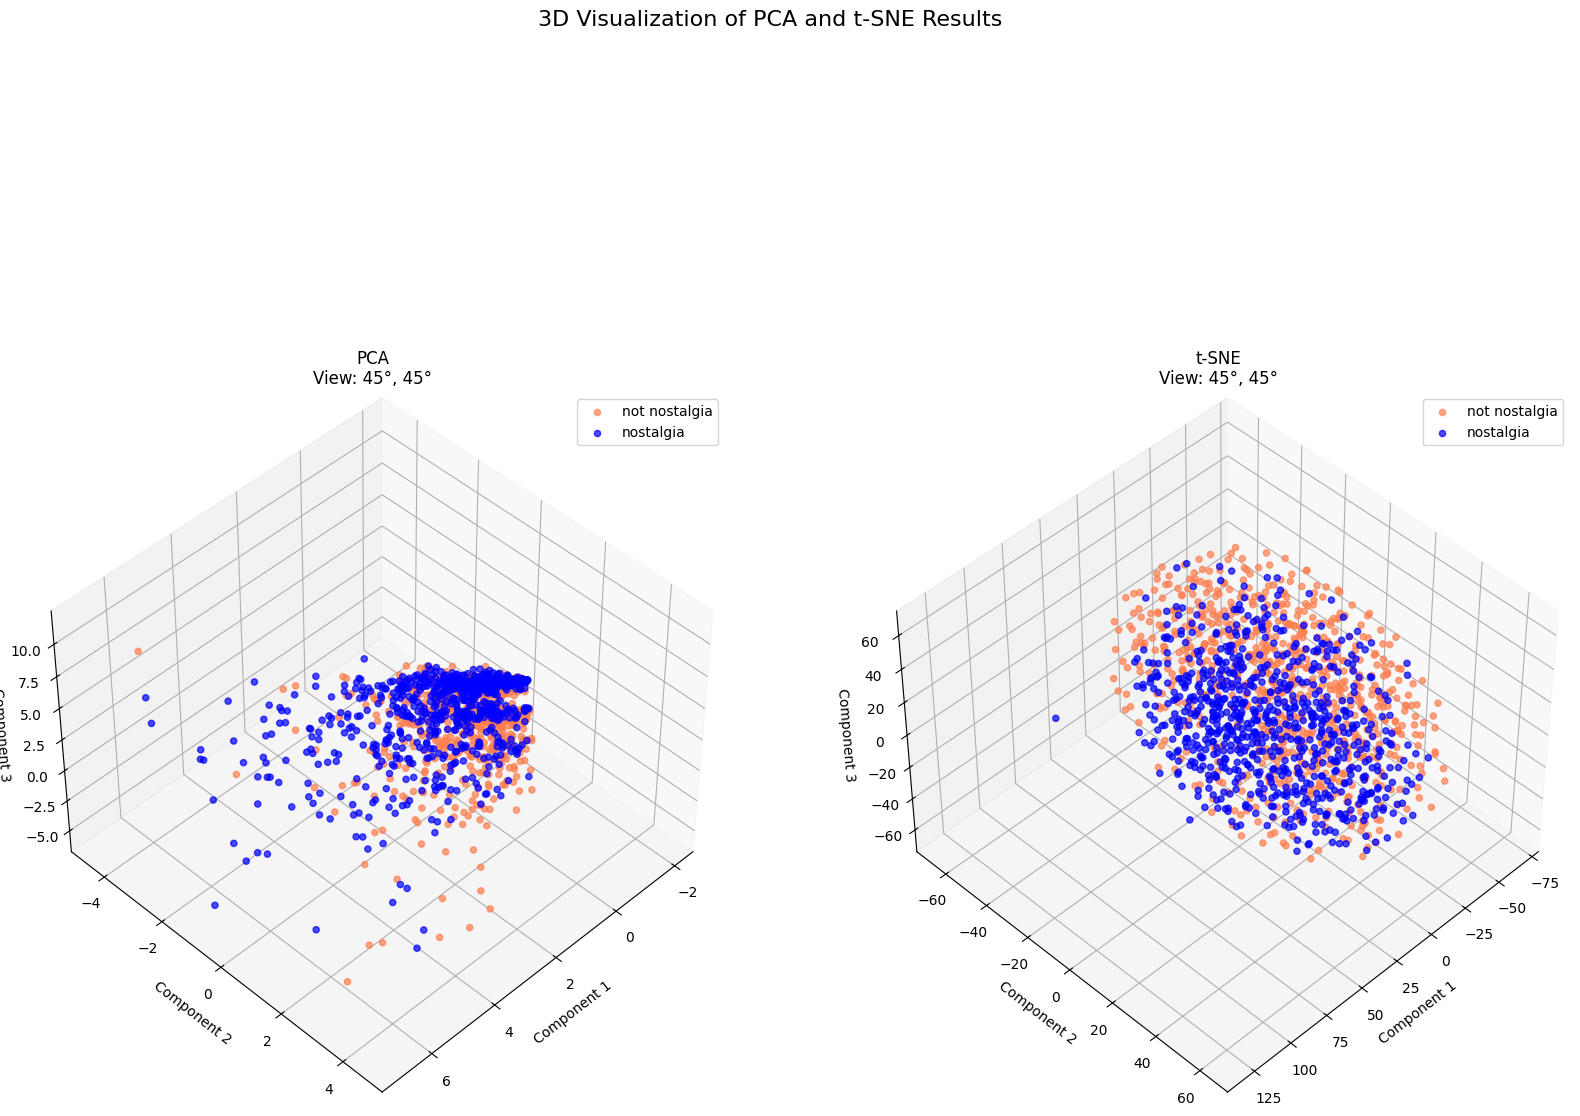

In [216]:
# Plot the results in subplots
pca = PCA(n_components=3)
tsne = TSNE(n_components=3)
X_pca_aug = pca.fit_transform(augmented_df.values)
X_tsne_aug = tsne.fit_transform(augmented_df.values)

col = ['coral', 'blue', 'black', 'orange']
categories = data_df['sentiment'].unique() 


# Create figure with subplots for both PCA and t-SNE
fig = plt.figure(figsize=(20, 30))
fig.suptitle('3D Visualization of PCA and t-SNE Results', fontsize=16, y=0.95)


def plot_3d_scatter(ax, X_reduced, title, view_angle):
    for c, category in zip(col, categories):
        xs = X_reduced[data_df['sentiment'] == category].T[0]
        ys = X_reduced[data_df['sentiment'] == category].T[1]
        zs = X_reduced[data_df['sentiment'] == category].T[2]
        ax.scatter(xs, ys, zs, c=c, marker='o', label=category, alpha=0.7)
    
    ax.grid(True)
    ax.set_title(f'{title}\nView: {view_angle[0]}°, {view_angle[1]}°')
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_zlabel('Component 3')
    ax.legend(loc='upper right')
    ax.view_init(elev=view_angle[0], azim=view_angle[1])

# Create subplots for PCA
ax1 = fig.add_subplot(221, projection='3d')
plot_3d_scatter(ax1, X_pca_aug, 'PCA', view_angle=(45, 45))

# Create subplots for t-SNE
ax2 = fig.add_subplot(222, projection='3d')
plot_3d_scatter(ax2, X_tsne_aug, 't-SNE', view_angle=(45, 45))


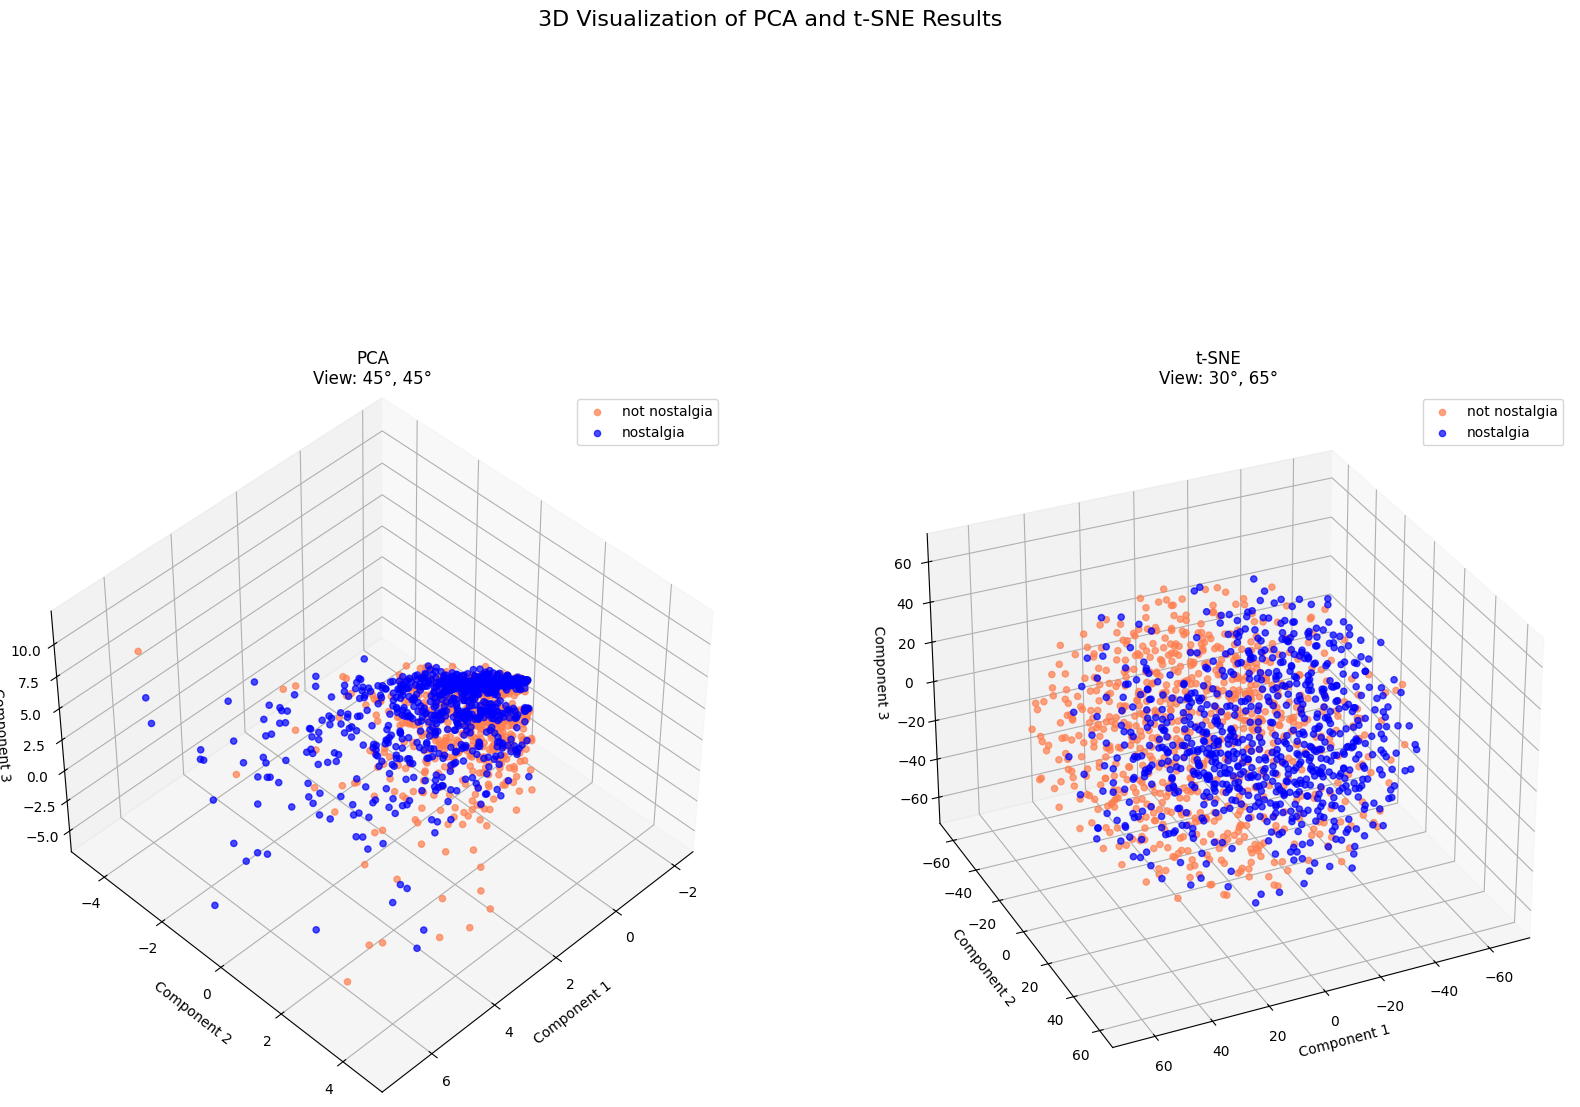

In [213]:
# Create figure with subplots for both PCA and t-SNE
fig = plt.figure(figsize=(20, 30))
fig.suptitle('3D Visualization of PCA and t-SNE Results', fontsize=16, y=0.95)


def plot_3d_scatter(ax, X_reduced, title, view_angle):
    for c, category in zip(col, categories):
        xs = X_reduced[data_df['sentiment'] == category].T[0]
        ys = X_reduced[data_df['sentiment'] == category].T[1]
        zs = X_reduced[data_df['sentiment'] == category].T[2]
        ax.scatter(xs, ys, zs, c=c, marker='o', label=category, alpha=0.7)
    
    ax.grid(True)
    ax.set_title(f'{title}\nView: {view_angle[0]}°, {view_angle[1]}°')
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_zlabel('Component 3')
    ax.legend(loc='upper right')
    ax.view_init(elev=view_angle[0], azim=view_angle[1])

# Create subplots for PCA
ax1 = fig.add_subplot(221, projection='3d')
plot_3d_scatter(ax1, X_pca_aug, 'PCA', view_angle=(45, 45))

# Create subplots for t-SNE
ax2 = fig.add_subplot(222, projection='3d')
plot_3d_scatter(ax2, X_tsne_aug, 't-SNE', view_angle=(30, 65))

In [220]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

# Create a mapping from numerical labels to category names
category_mapping = dict(X[['category', 'category_name']].drop_duplicates().values)

# Convert the numerical category labels to text labels
target_names = [category_mapping[label] for label in sorted(category_mapping.keys())]

# Split the data into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(tdm_df, X['category'], test_size=0.3, random_state=42)

array([0.07519501, 0.04028964, 0.0277074 ])

In [231]:
from sklearn import preprocessing
mlb = preprocessing.LabelBinarizer()
mlb.fit(data_df['sentiment'])
data_df['bin_sentiment'] = mlb.transform(data_df['sentiment'])

In [232]:
data_df['bin_sentiment']

0       1
1       0
2       0
3       1
4       0
       ..
1495    1
1496    1
1497    1
1498    0
1499    0
Name: bin_sentiment, Length: 1499, dtype: int64

In [234]:
#Model with only the document-term frequency data
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

# Create a mapping from numerical labels to category names
category_mapping = dict(data_df[['bin_sentiment', 'sentiment']].drop_duplicates().values)

# Convert the numerical category labels to text labels
target_names = [category_mapping[label] for label in sorted(category_mapping.keys())]

# Split the data into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(tdm_df, data_df['sentiment'], test_size=0.3, random_state=42)

In [235]:
# Train the Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = nb_classifier.predict(X_test)

# Evaluate the classifier
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=target_names, digits=4))

Accuracy: 0.8688888888888889

Classification Report:
                precision    recall  f1-score   support

    nostalgia     0.8222    0.9528    0.8827       233
not nostalgia     0.9389    0.7788    0.8514       217

     accuracy                         0.8689       450
    macro avg     0.8806    0.8658    0.8670       450
 weighted avg     0.8785    0.8689    0.8676       450

